<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Synthetic-Data---ARMA(1,1)" data-toc-modified-id="Synthetic-Data---ARMA(1,1)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Synthetic Data - ARMA(1,1)</a></span></li><li><span><a href="#Statsmodels" data-toc-modified-id="Statsmodels-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Statsmodels</a></span></li><li><span><a href="#PyMC" data-toc-modified-id="PyMC-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>PyMC</a></span><ul class="toc-item"><li><span><a href="#Prior-Predictive" data-toc-modified-id="Prior-Predictive-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Prior Predictive</a></span><ul class="toc-item"><li><span><a href="#Unconditional" data-toc-modified-id="Unconditional-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Unconditional</a></span></li><li><span><a href="#Conditional" data-toc-modified-id="Conditional-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Conditional</a></span></li></ul></li></ul></li><li><span><a href="#Estimation" data-toc-modified-id="Estimation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Estimation</a></span></li><li><span><a href="#Posterior-Predictive" data-toc-modified-id="Posterior-Predictive-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Posterior Predictive</a></span><ul class="toc-item"><li><span><a href="#Unconditional" data-toc-modified-id="Unconditional-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Unconditional</a></span></li><li><span><a href="#Conditional" data-toc-modified-id="Conditional-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Conditional</a></span></li></ul></li><li><span><a href="#Predictions-Compared" data-toc-modified-id="Predictions-Compared-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Predictions Compared</a></span></li></ul></div>

In [1]:
%matplotlib inline
import sys

sys.path.append("..")

import jax

jax.config.update("jax_platform_name", "cpu")

import numpyro

numpyro.set_host_device_count(4)

import pymc as pm
import pytensor
from pytensor import tensor as pt

import arviz as az
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

import pymc_experimental.statespace as pmss

config = {
    "figure.figsize": [12.0, 4.0],
    "figure.dpi": 72.0 * 2,
    "figure.facecolor": "w",
    "axes.grid": True,
    "grid.linewidth": 0.5,
    "grid.linestyle": "--",
    "axes.spines.top": False,
    "axes.spines.bottom": False,
    "axes.spines.left": False,
    "axes.spines.right": False,
}

plt.rcParams.update(config)

# Synthetic Data - ARMA(1,1)

Start very simple because I don't want to worry about stationarity at higher orders of p,q 

In [2]:
seed = sum(map(ord, "statespace arima"))
rng = np.random.default_rng(seed)

AR_params = [0.8, 0.0]
MA_params = [-0.5]

# Initial state
x0 = np.r_[[0.0], [0.0]]

# Hidden state transition matrix
T = np.array([[AR_params[0], 1.0], [AR_params[1], 0.0]])

# Hidden state noise coefficients
R = np.array([[1.0], [MA_params[0]]])

# Hidden state covaraince matrix
Q = np.array([[0.8]])

# Observation matrix
Z = np.array([[1.0, 0.0]])

# Observation noise covariance
H = np.array([[0.0]])

timesteps = 100
data = np.zeros(timesteps)
hidden_states = np.zeros((timesteps, 2))
hidden_states[0, :] = x0

innovations = rng.multivariate_normal(mean=np.array([0.0]), cov=Q, size=timesteps)

for t in range(1, timesteps):
    hidden_states[t] = T @ hidden_states[t - 1, :] + R @ np.atleast_1d(innovations[t])
    data[t] = Z @ hidden_states[t]

fake_dates = pd.date_range("2010-01-01", freq="MS", periods=data.shape[0])
df = pd.DataFrame(data, columns=["state"], index=fake_dates)

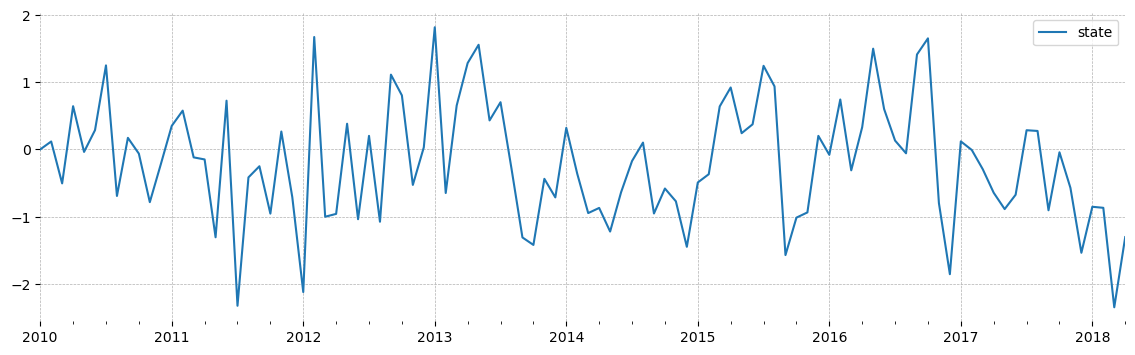

In [3]:
fig, ax = plt.subplots(figsize=(14, 4), dpi=100)
df.plot(ax=ax)
plt.show()

# Statsmodels

In [4]:
mod = sm.tsa.SARIMAX(endog=data, order=(1, 0, 1))
res = mod.fit(disp=0)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -128.446
Date:                Sat, 05 Aug 2023   AIC                            262.892
Time:                        05:57:25   BIC                            270.708
Sample:                             0   HQIC                           266.055
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8077      0.174      4.632      0.000       0.466       1.150
ma.L1         -0.6162      0.231     -2.670      0.008      -1.069      -0.164
sigma2         0.7630      0.109      6.990      0.000       0.549       0.977
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 0.02
Prob(Q):                              0.84   Prob(JB):                         0.99
Heteroskedasticity (H):               0.97   Skew:                            -0.03
Prob(H) (two-sided):                  0.93   Kurtosis:                         3.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# PyMC

Unlike the local level model, we don't need to explicitly estimate the inital statae or covaraince matrix for an ARIMA model, **if** the model dynamics are guaranteed to be stationary. Since we have an AR(1), that means the autoregressive parameter must be less than 1 in absolute value. In this case, closed formed solutions for the steady-state of the system can be used for the initial state:

$$x^\star = (I - T)^{-1}c$$

The covariance matrix is more complex, but can be obtained by solving this quadratic matrix equation (known as a "discrete lyapunov equation"):

$$TP^{\star} T^T - P^{\star} + R Q R^T = 0$$

In [5]:
ss_mod = pmss.BayesianARIMA(order=(1, 0, 1), verbose=True)

The following parameters should be assigned priors inside a PyMC model block: 
	ar_params -- shape: (1,), constraints: None, dims: ('ar_lag',)
	ma_params -- shape: (1,), constraints: None, dims: ('ma_lag',)
	sigma_state -- shape: (1,), constraints: Positive, dims: ('observed_state',)


In [6]:
ss_mod.coords

{'state': ['data', 'state_1'],
 'state_aux': ['data', 'state_1'],
 'observed_state': ['data'],
 'observed_state_aux': ['data'],
 'shock': ['innovation'],
 'shock_aux': ['innovation'],
 'ar_lag': [1],
 'ma_lag': [1]}

In [7]:
ss_mod.param_dims

{'sigma_state': ('observed_state',),
 'ar_params': ('ar_lag',),
 'ma_params': ('ma_lag',)}

In [8]:
with pm.Model(coords=ss_mod.coords) as arma_model:
    state_sigmas = pm.Gamma("sigma_state", alpha=10, beta=2, dims=ss_mod.param_dims["sigma_state"])
    rho = pm.Beta("ar_params", alpha=5, beta=1, dims=ss_mod.param_dims["ar_params"])
    theta = pm.Normal("ma_params", mu=0.0, sigma=0.5, dims=ss_mod.param_dims["ma_params"])

    ss_mod.build_statespace_graph(df, mode="JAX")
    prior = pm.sample_prior_predictive(compile_kwargs={"mode": "JAX"})

/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/site-packages/pytensor/link/jax/linker.py:28: UserWarning: The RandomType SharedVariables [RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7F8AAFACE180>), RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7F8AB0926CE0>), RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7F8AB0927300>), RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7F8ABDE87AE0>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/functools.py:909: UserWarning: Skipping `CheckAndRaise` Op (assertion: Could not broadcast dimensions. Broadcasting is only allowed along axes that have a statically known length 1. Use `specify_broadcastable` to inform PyTensor of a known shape.) as JAX tracing would remove it.
  return dispatch(args[0].__class__)(*args, **kw)
/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/functools.py:909: UserWarning: Skipp

## Prior Predictive

### Unconditional

A note about what the states are, first of all. For an ARMA (1,1) model, the state space transition equation is:

$$ \begin{bmatrix} y_{t+1} \\ x_{t+1} \end{bmatrix} = 
    \begin{bmatrix}\rho & 1 \\ 0 & 0 \end{bmatrix} \begin{bmatrix} y_t \\ x_t \end{bmatrix} + 
    \begin{bmatrix} 1 \\ \theta \end{bmatrix} \varepsilon_{t+1}
    $$
    
Which, if you work out the matrix multiplications, gives two state equations:

$$\begin{align} y_{t+1} &= \rho y_t + x_t + \varepsilon_{t+1} \\
    x_{t+1} &= \theta \varepsilon_{t+1} \end{align}$$
    
So the two states we end up with are the modeled data ($y_{t+1}$), and the innovation series, scaled by $\theta$. To recover the estimated innovations, you would need to divide the second state by $\theta$. It is also possible to write it such that the innovations are "carried along", but it doubles the number of states required. This is probably fine for small values of p and q, but bad for larger ones, since the Kalman filter needs to invert a matrix of size $k \times k$ each iteration.

Anyway, we can two different types of trajectories in the priors. One is sharp and jagged, when rho/theta are large and negative. The other is smooth and meandering, when rho is positive and reasonable. When rho is very close to 1, we get the trajectories that wander out to +/- 20.

In [9]:
unconditional_prior = ss_mod.sample_unconditional_prior(prior)

/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/site-packages/pytensor/link/jax/linker.py:28: UserWarning: The RandomType SharedVariables [RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7F8A9C47D0E0>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [prior_combined]


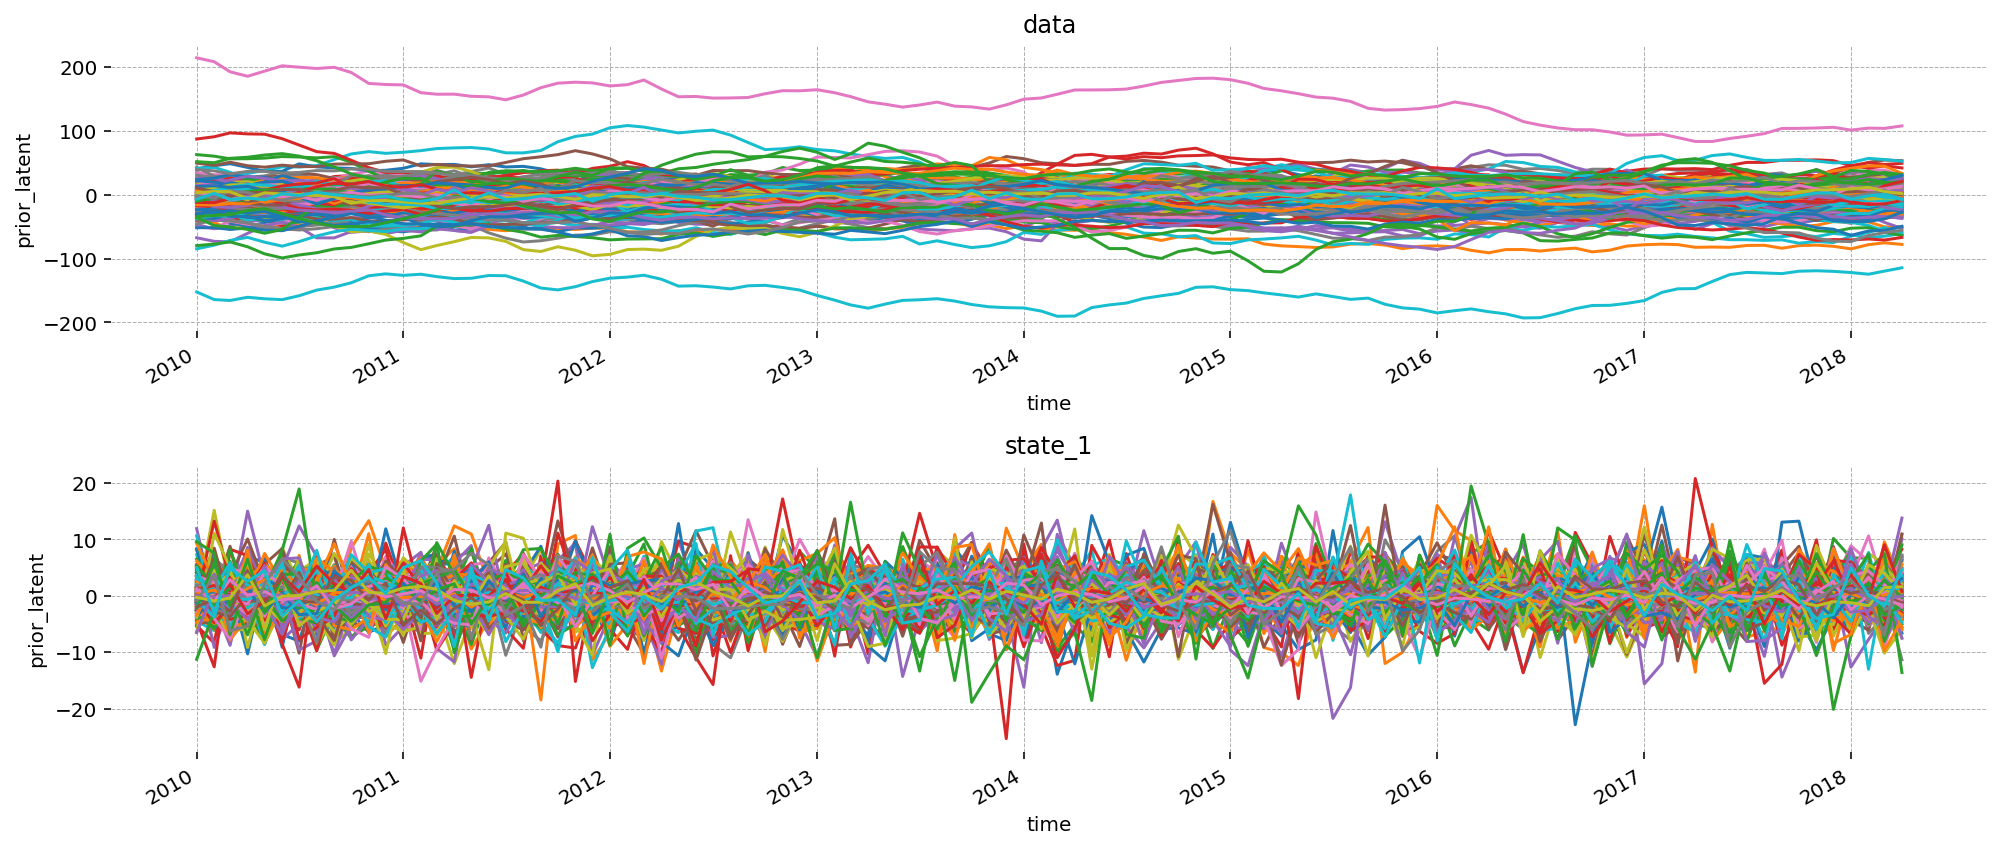

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(14, 6), dpi=144)
for idx, (axis, state) in enumerate(zip(fig.axes, ss_mod.state_names)):
    unconditional_prior.prior_latent.sel(state=state).stack(sample=["chain", "draw"]).plot.line(
        x="time", ax=axis, add_legend=False
    )
    axis.set(title=state)

fig.set_facecolor("w")
fig.tight_layout()
plt.show()

### Conditional

The conditional outputs for the kalman smoother and filter aren't as interesting for this model, because the process noise doesn't have full rank. That is, only the second state, associated with the MA process, has noise added. The result is that the first state noiselessly encodes the data. Let's have a look!

In [11]:
conditional_prior = ss_mod.sample_conditional_prior(prior)

/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/site-packages/pytensor/link/jax/linker.py:28: UserWarning: The RandomType SharedVariables [RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7F8A58679C40>), RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7F8A5867AB20>), RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7F8A584EC3C0>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/functools.py:909: UserWarning: Skipping `CheckAndRaise` Op (assertion: Could not broadcast dimensions. Broadcasting is only allowed along axes that have a statically known length 1. Use `specify_broadcastable` to inform PyTensor of a known shape.) as JAX tracing would remove it.
  return dispatch(args[0].__class__)(*args, **kw)
Sampling: [filtered_prior, predicted_prior, smoothed_prior]


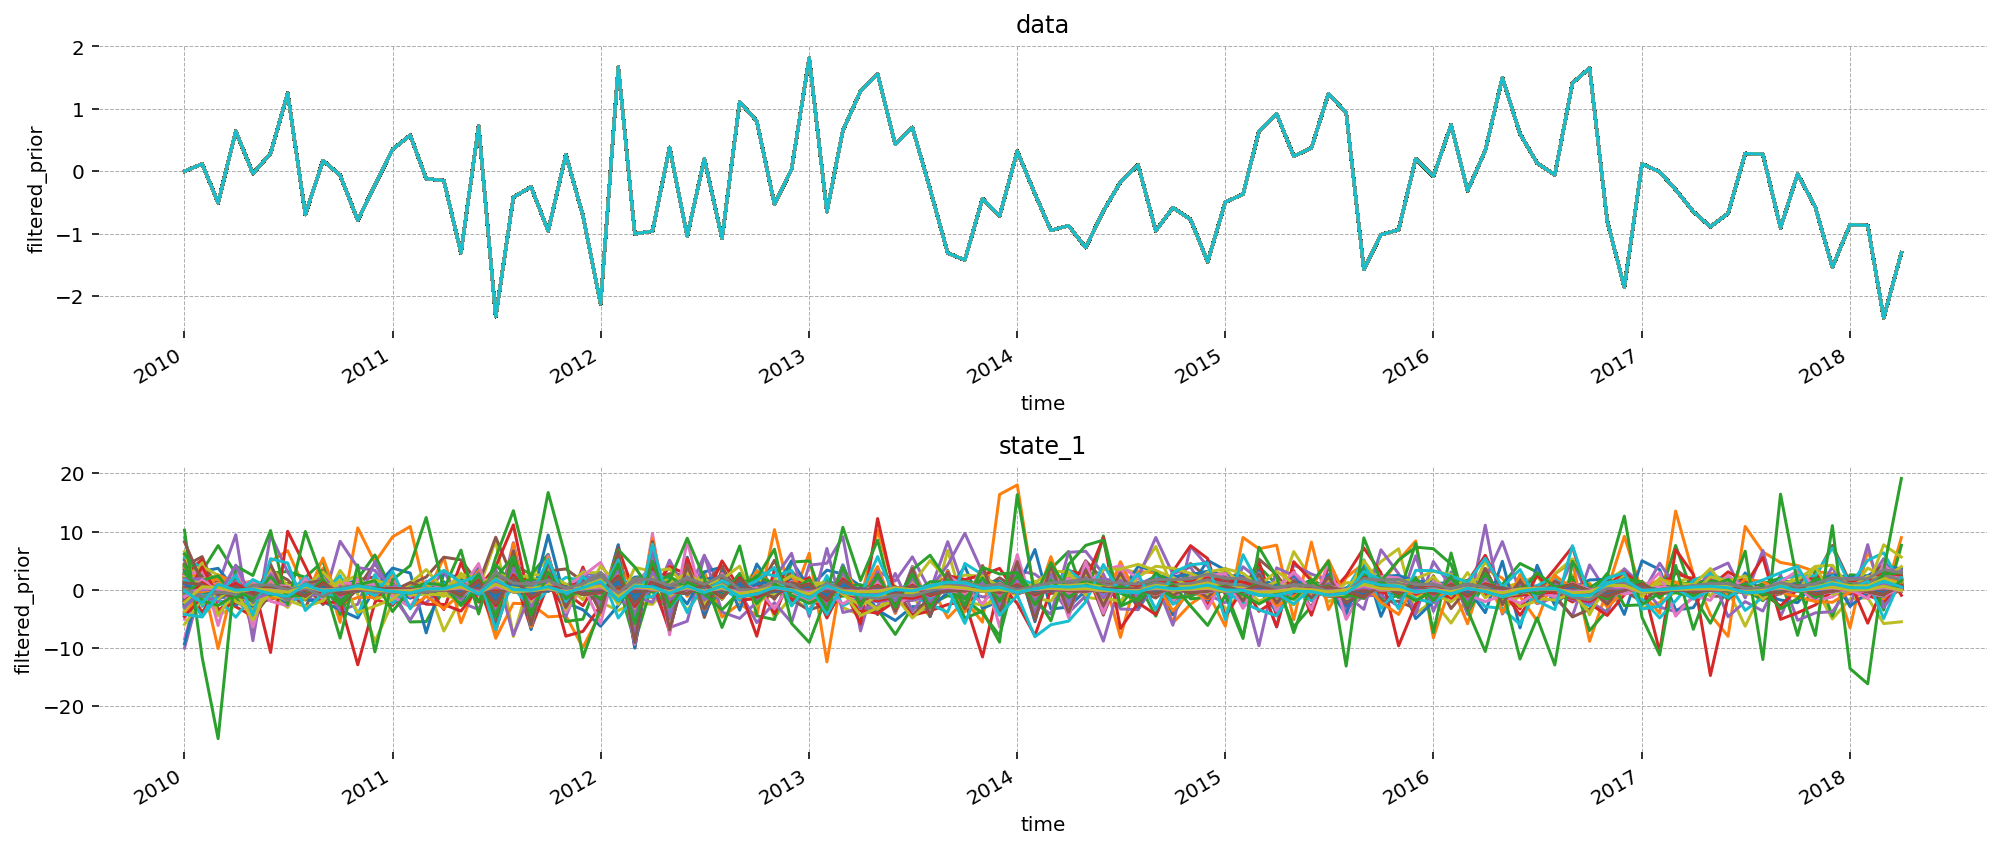

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(14, 6), dpi=144)
for idx, (axis, state) in enumerate(zip(fig.axes, ss_mod.state_names)):
    conditional_prior.filtered_prior.sel(state=state).stack(sample=["chain", "draw"]).plot.line(
        x="time", ax=axis, add_legend=False
    )
    axis.set(title=state)

fig.set_facecolor("w")
fig.tight_layout()
plt.show()

We can ask for the kalman predictions, $\mathbb E\left [ x_{t+1} | \{y_\tau\}_{\tau=0}^{t} \right]$, which are a bit more interesting, by passing `filter_output = 'prediced'` to the `sample_conditional_prior` method

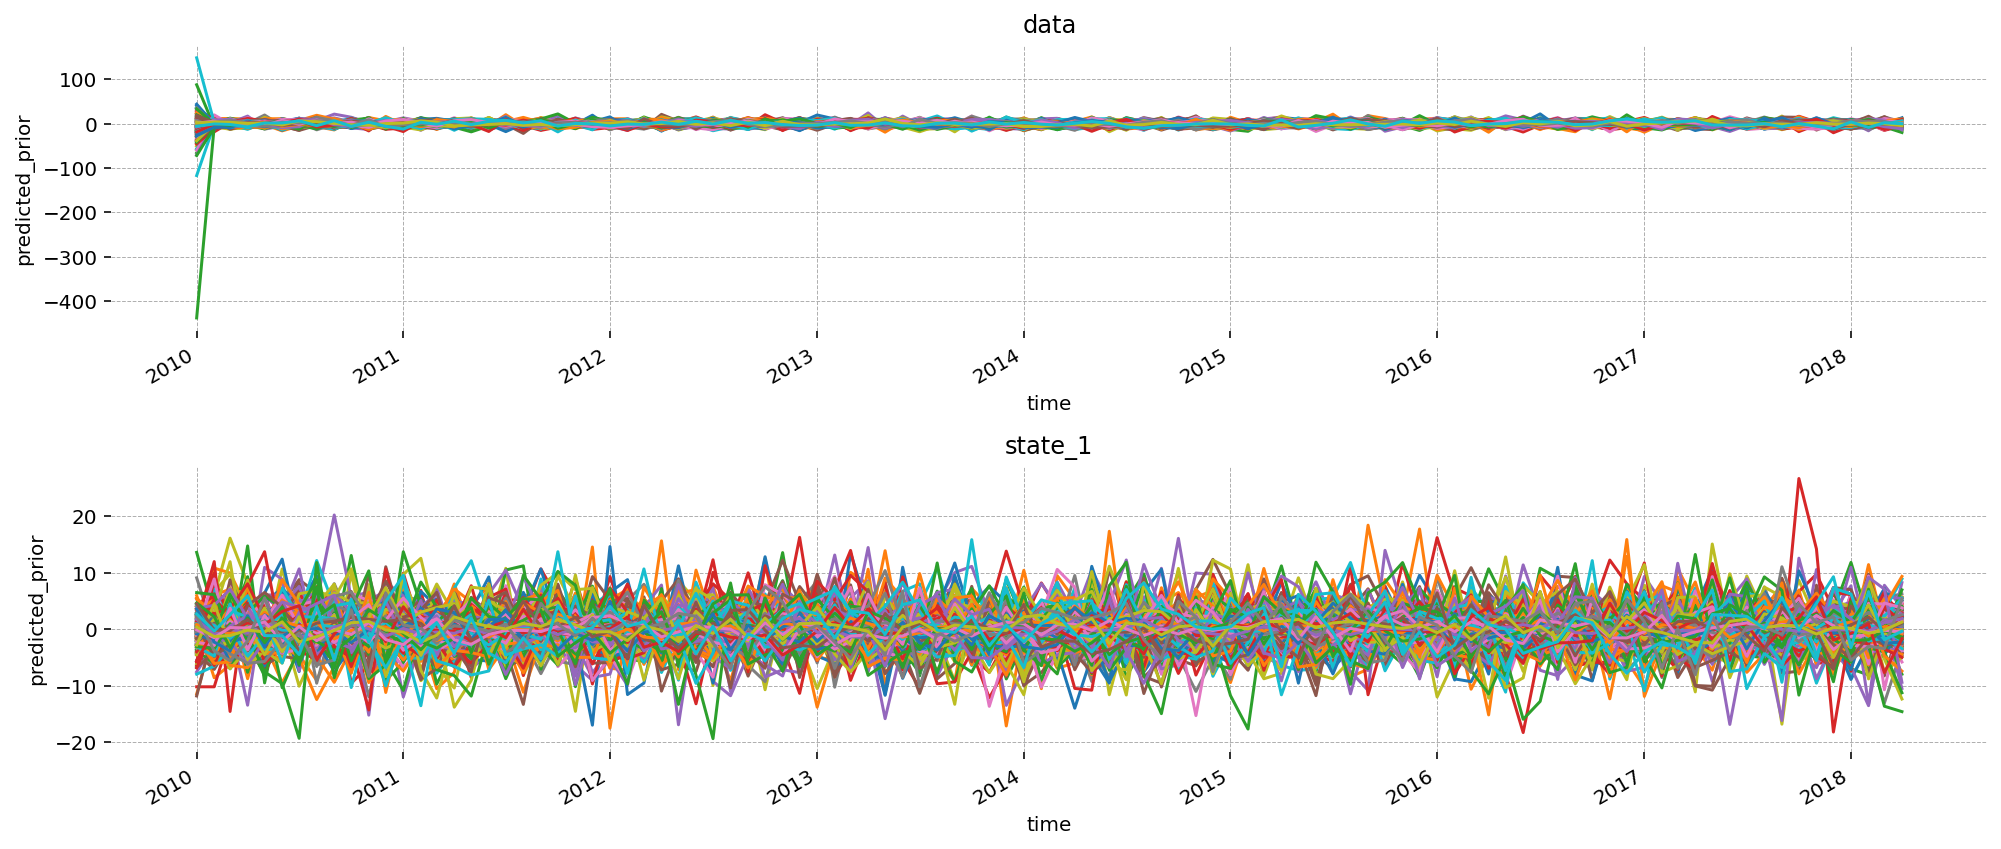

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(14, 6), dpi=144)
for idx, (axis, state) in enumerate(zip(fig.axes, ss_mod.state_names)):
    conditional_prior.predicted_prior.sel(state=state).stack(sample=["chain", "draw"]).plot.line(
        x="time", ax=axis, add_legend=False
    )
    axis.set(title=state)

fig.set_facecolor("w")
fig.tight_layout()
plt.show()

# Estimation

Finally on to actually fitting the model. There are ways to speed things up a bit. We are using stationary covariance initialization, which saves us from estimating the intial covaraince matrix. PyMC Statespace also offers different flavors of Kalman Filter, some with some built in speedups (`steady_state`). 

For now we'll just go with the standard filter. There is a separate notbook explaining and comparing the different filtering choices.

In [14]:
with arma_model:
    idata = pm.sample(nuts_sampler="numpyro")

/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/site-packages/pymc/sampling/mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:06.742057
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:18.975371
Transforming variables...
Transformation time =  0:00:06.610085


/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/site-packages/arviz/utils.py:185: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


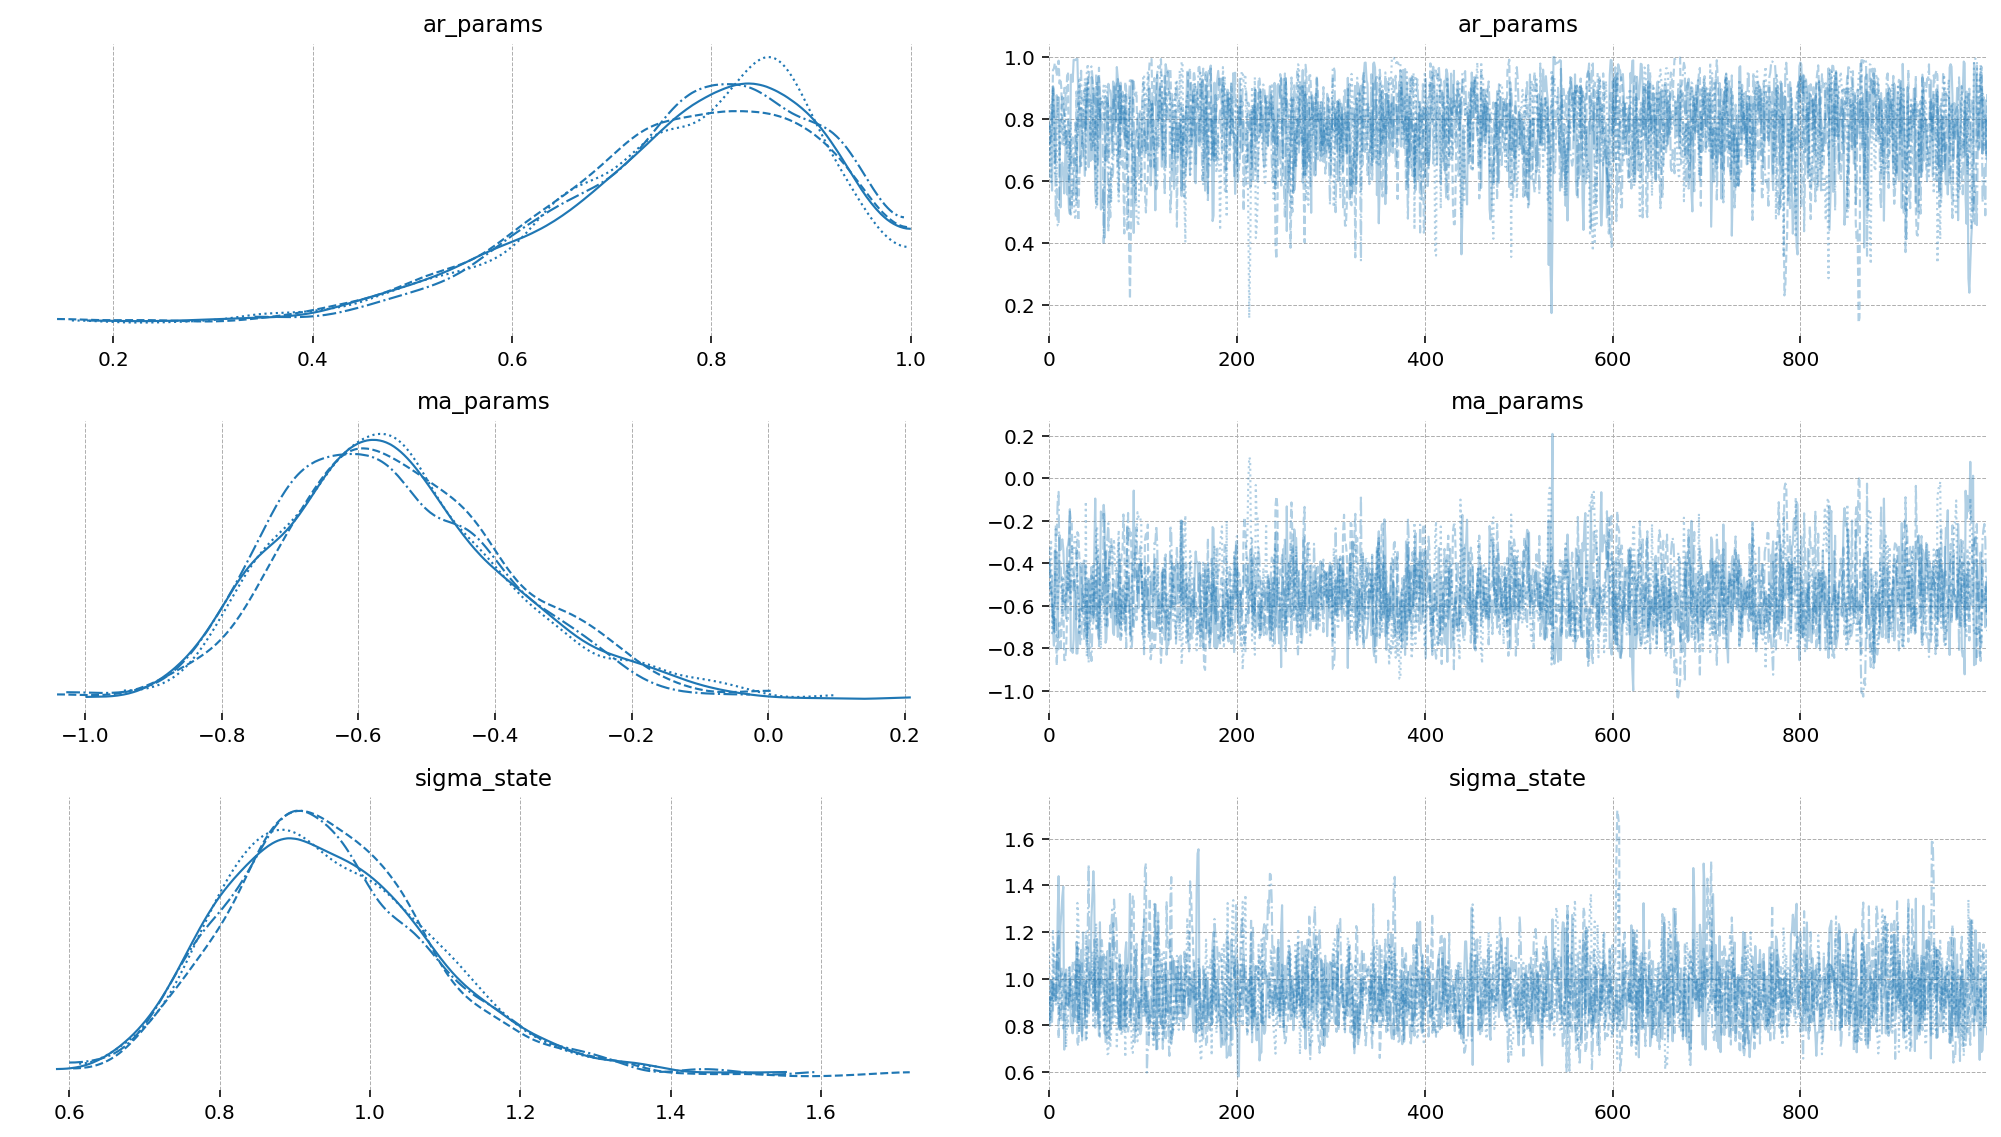

In [15]:
fig, ax = plt.subplots(3, 2, figsize=(14, 8))
az.plot_trace(idata, var_names=ss_mod.param_names, axes=ax)
fig.tight_layout()
plt.show()

Posterior estimates are reasonable, and the true value is contained in the 94% HDI in each case. Looks like the ML estimator did a bit better, but we also estimated 4 more parameters than it did (2 initial states, plus 2 initial covariances!)

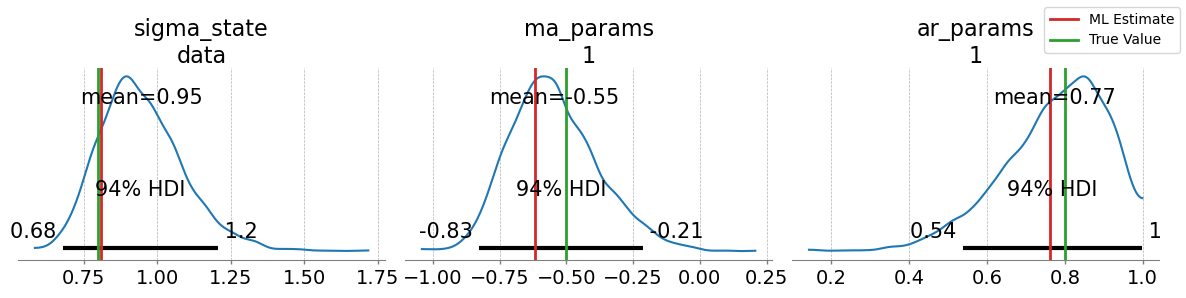

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3), dpi=100)
az.plot_posterior(idata, var_names=["sigma_state", "ma_params", "ar_params"], ax=ax)
ax[0].axvline(res.params[0], color="tab:red", lw=2, label="ML Estimate")
ax[1].axvline(res.params[1], color="tab:red", lw=2)
ax[2].axvline(res.params[2], color="tab:red", lw=2)

ax[0].axvline(0.8, color="tab:green", lw=2, label="True Value")
ax[1].axvline(-0.5, color="tab:green", lw=2)
ax[2].axvline(0.8, color="tab:green", lw=2)


fig.set(facecolor="white")
fig.tight_layout()
fig.legend()
plt.show()

# Posterior Predictive

## Unconditional

In [17]:
unconditional_post = ss_mod.sample_unconditional_posterior(
    idata, steps=100, use_data_time_dim=False
)
post = az.extract(unconditional_post, "posterior_predictive")

/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/site-packages/pytensor/link/jax/linker.py:28: UserWarning: The RandomType SharedVariables [RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7F8A21952F80>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [posterior_combined]


Notice how there's no more trajectories that diverge away from the mean. The posterior rules out values of $\rho$ close to 1. Since we ended up with a stationary model, the long-term unconditional dynamics converge to a steady state mean and covariance matrix, which is what we are seeing here.

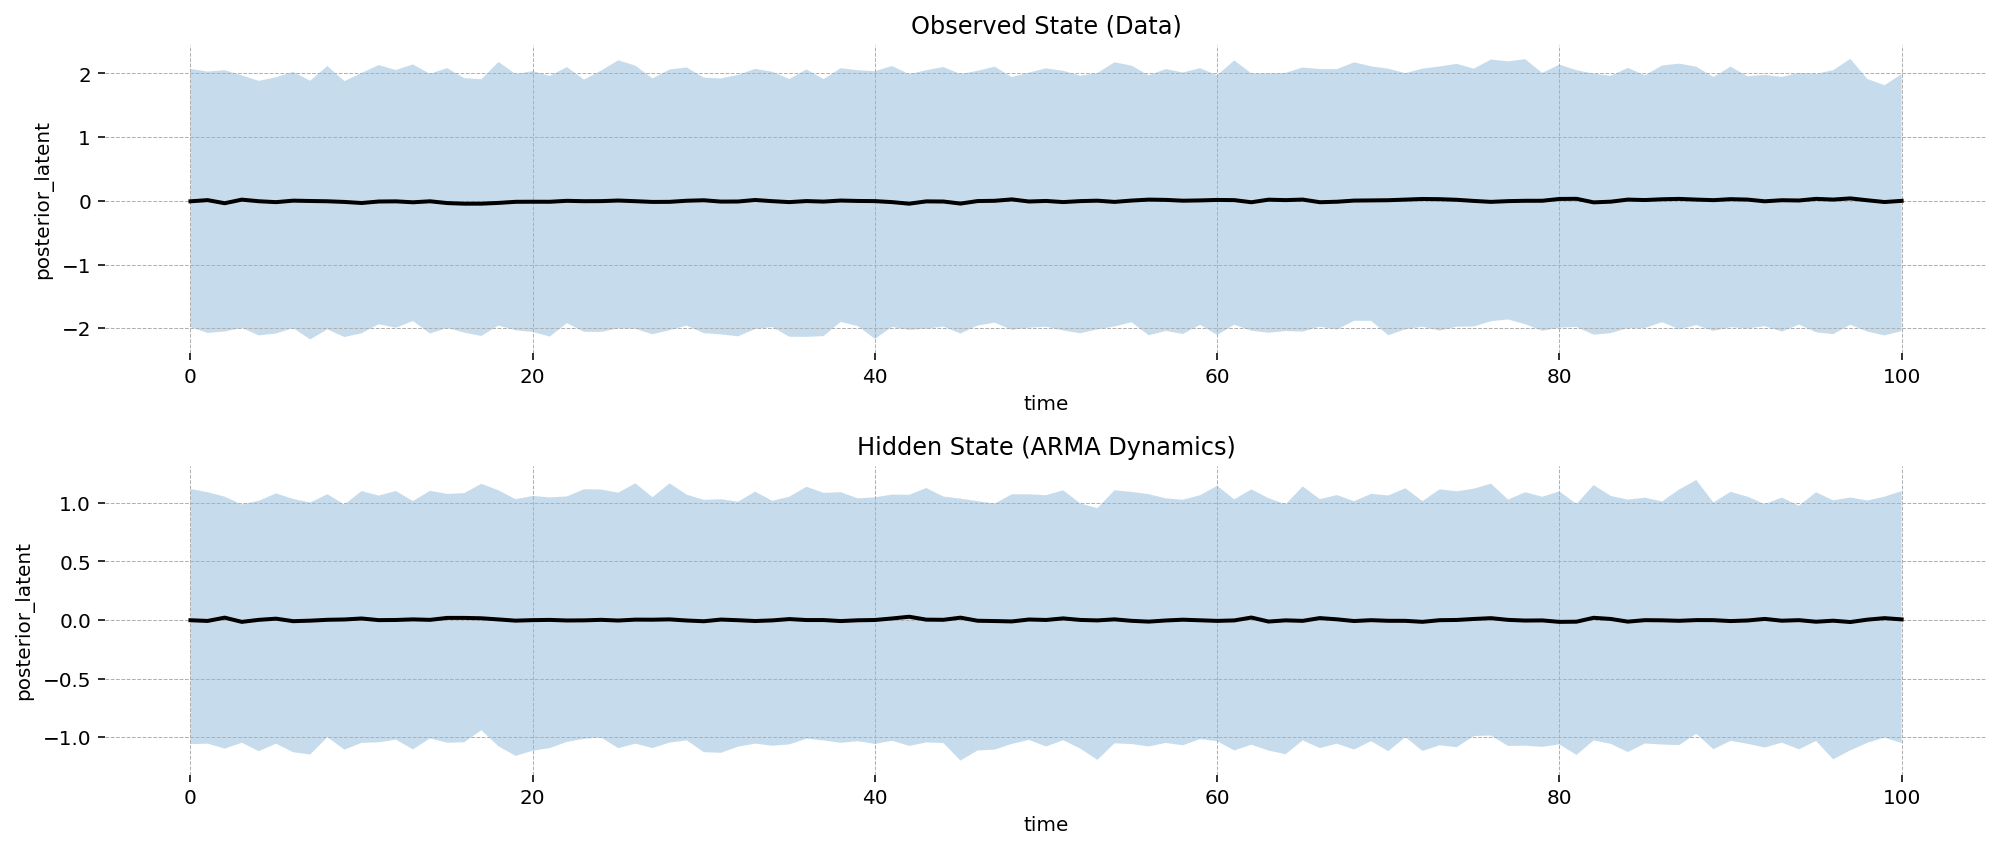

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(14, 6), dpi=144)
hdi = az.hdi(unconditional_post.posterior_latent)

for idx, (axis, name) in enumerate(
    zip(fig.axes, ["Observed State (Data)", "Hidden State (ARMA Dynamics)"])
):
    post.isel(state=idx).mean(dim="sample").posterior_latent.plot.line(
        x="time", ax=axis, color="k", lw=2, add_legend=False
    )
    axis.fill_between(
        hdi.coords["time"], *hdi.isel(state=idx).posterior_latent.values.T, alpha=0.25
    )
    axis.set(title=name)

fig.set_facecolor("w")
fig.tight_layout()
plt.show()

As a model check, we can compute the closed-form steady state distributon of the statespace system under the posterior and check whether the simulations are convering to it. The closed form mean and covariance matrix are:

$$\begin{align}
\mu^\star &= (I - T)^{-1} c \\
\Sigma^\star &= T \Sigma^\star T^T − T \Sigma^\star Z^T F{-1} Z \Sigma^\star T^T + R Q R^T
\end{align}$$

The first equation assumes that $T$ is invertable, which means that the system needs to be stationary. These results thus don't apply to, say, a Gaussian Random Walk model. The second equation is a Discrete Matrix Riccati Equation. A `pytensor` solver is available, but is not JAX compaible.

In [19]:
from pymc_experimental.statespace.utils.pytensor_scipy import solve_discrete_are

with pm.Model(coords=ss_mod.coords):
    x0, P0, c, d, T, Z, R, H, Q = ss_mod._build_dummy_graph()
    mu_star = pm.Deterministic(
        "mu_star", pt.linalg.inv(pt.eye(ss_mod.k_states) - T) @ c, dims=["state"]
    )
    Sigma_star = pm.Deterministic(
        "Sigma_star", solve_discrete_are(T.T, Z.T, R @ Q @ R.T, H), dims=["state", "state_aux"]
    )

    idata_steady = pm.sample_posterior_predictive(
        idata, var_names=["mu_star", "Sigma_star"], random_seed=1337
    )

Sampling: []


After 100 time steps, it looks like the covariance of the samples is approaching the analyical posterior covariance.

In [20]:
np.cov(post.posterior_latent.isel(time=-1).values)

array([[ 1.21630661, -0.52879629],
       [-0.52879629,  0.31529603]])

In [21]:
idata_steady.posterior_predictive.mean(dim=["chain", "draw"]).Sigma_star.values

array([[ 0.94675382, -0.51579471],
       [-0.51579471,  0.30744202]])

## Conditional

In [22]:
post_pred = ss_mod.sample_conditional_posterior(idata)

/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/site-packages/pytensor/link/jax/linker.py:28: UserWarning: The RandomType SharedVariables [RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7F89BF744740>), RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7F89BF747060>), RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7F89BF746CE0>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [filtered_posterior, predicted_posterior, smoothed_posterior]


Comparing the posterior outputs, you can see that only the Kalman predictions have posterior errors. This is because there is no measurement error in this model, nor unobserved shocks to the hidden states. In the context of the Kalman Filter, this has the effect of noiselessly encoding the data during the filter step (and the smoother is based on the filtered distribution). 

In all three posterior predicitive distributions, we can see that there is noise in the hidden state estimation. This amounts to estimation of the innovation series, scaled by the MA parameter $\theta$ (refer to the algebra above). This amounts to draws from a fixed Normal distribution in the filtered and predictive distributions, but more closely follows the data in the smoothed distirbution, since this takes into account both past and future observations. 

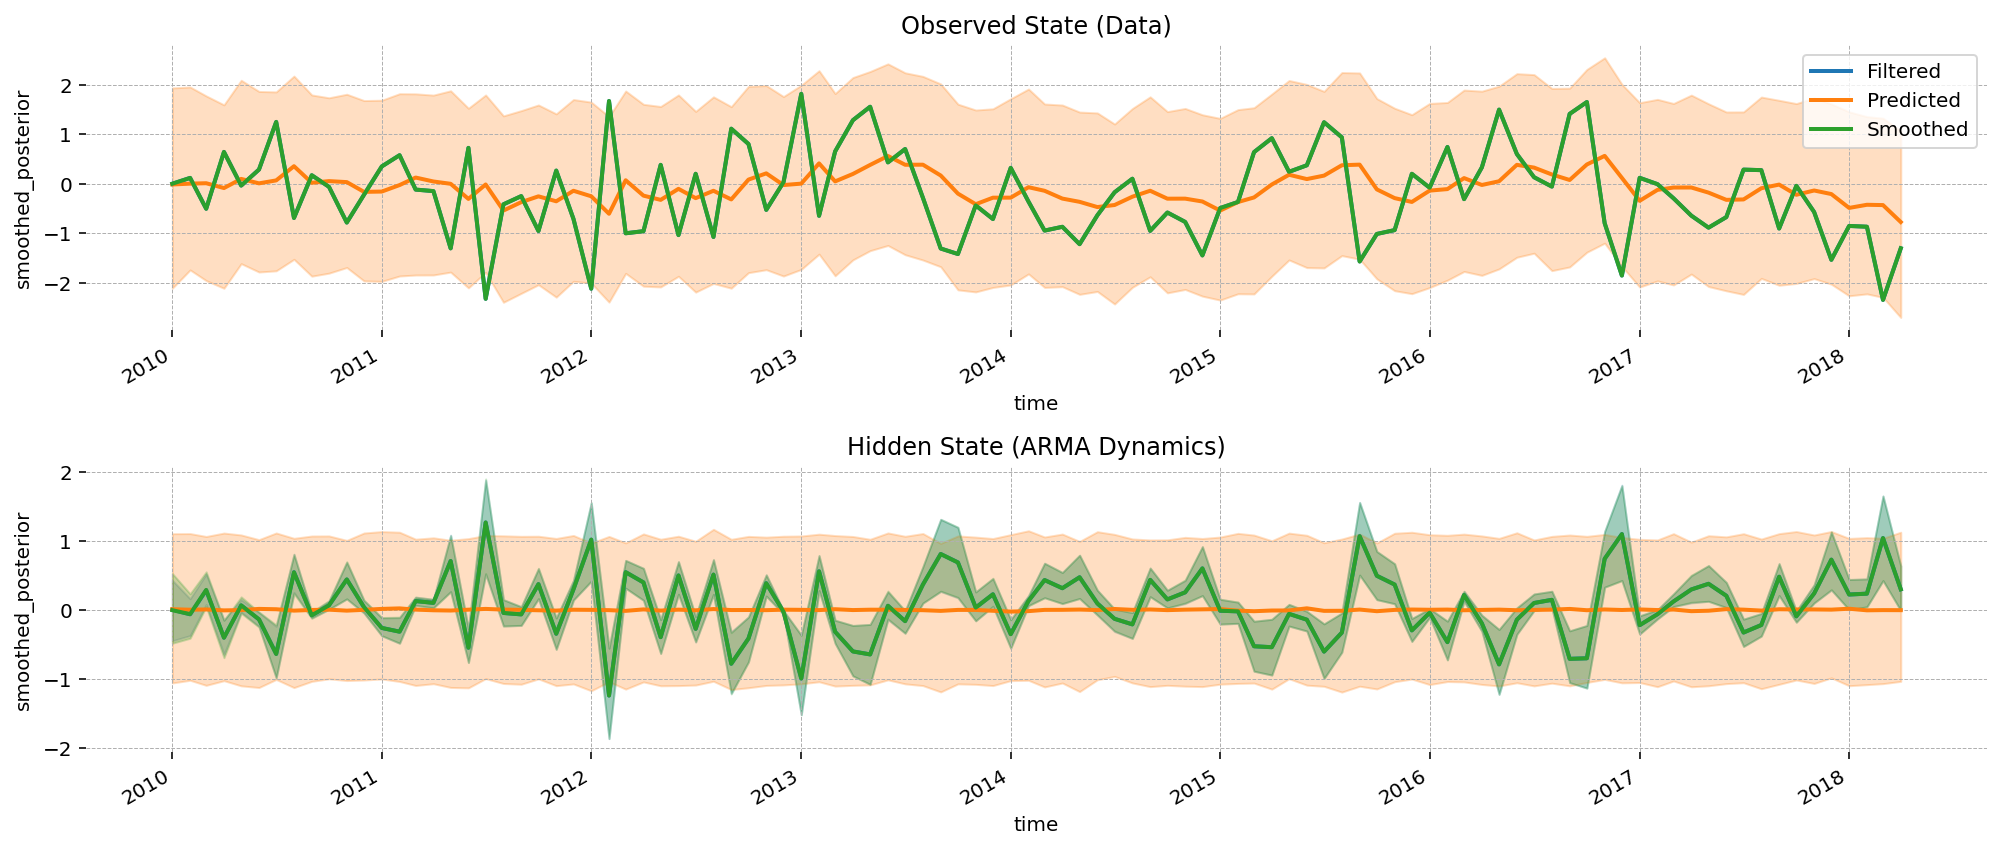

In [23]:
fig, ax = plt.subplots(2, 1, figsize=(14, 6), dpi=144)
post = az.extract(post_pred, "posterior_predictive")
colors = ["tab:" + c for c in ["blue", "orange", "green"]]

for filter_output, color in zip(["filtered", "predicted", "smoothed"], colors):
    hdi = az.hdi(post_pred)[f"{filter_output}_posterior"]
    for idx, (axis, name) in enumerate(
        zip(fig.axes, ["Observed State (Data)", "Hidden State (ARMA Dynamics)"])
    ):
        post[f"{filter_output}_posterior"].isel(state=idx).mean(dim="sample").plot.line(
            x="time", ax=axis, lw=2, add_legend=False, label=filter_output.title(), color=color
        )
        axis.fill_between(
            hdi.coords["time"], *hdi.isel(state=idx).values.T, alpha=0.25, color=color
        )
        axis.set(title=name)

ax[0].legend()
fig.set_facecolor("w")
fig.tight_layout()
plt.show()

# Predictions Compared

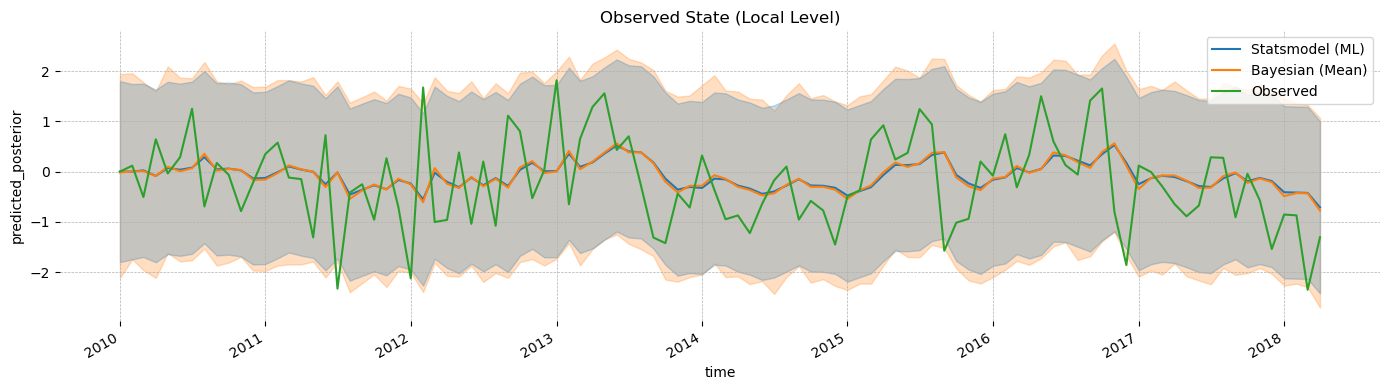

In [24]:
fig, ax = plt.subplots(figsize=(14, 4), dpi=100)
hdi = az.hdi(post_pred).predicted_posterior

ax.plot(df.index, res.states.predicted[:-1, 0], label="Statsmodel (ML)")
post.mean(dim="sample").isel(state=0).predicted_posterior.plot.line(
    x="time", label="Bayesian (Mean)"
)
ax.fill_between(
    df.index,
    *hdi.isel(state=0).values.T,
    alpha=0.25,
    color="tab:orange",
)

ml_mu = res.states.predicted[:-1, 0]
ml_var = res.states.predicted_cov.reshape(-1, 2, 2)[:-1, 0, 0]

ax.fill_between(
    df.index,
    ml_mu - 1.96 * np.sqrt(ml_var),
    ml_mu + 1.96 * np.sqrt(ml_var),
    alpha=0.25,
    color="tab:blue",
)

ax.plot(df.index, df.values, label="Observed")
ax.set(title="Observed State (Local Level)")
ax.legend()

fig.set(facecolor="white")
fig.tight_layout()
plt.show()

## Forecasting

Forcasting is also easy, just use the `forecast` method.

In [25]:
def plot_forecast(df, forecast):
    fig, ax = plt.subplots(figsize=(14, 4), dpi=100)
    ax.plot(df.index, df.values, label="Data")

    hdi_forecast = az.hdi(idata_forecast).forecast_observed

    forecast.mean(dim="sample").forecast_observed.isel(observed_state=0).plot.line(
        x="time", label="Forecast", add_legend=False
    )
    ax.fill_between(
        forecast.coords["time"].values,
        *hdi_forecast.isel(observed_state=0).values.T,
        alpha=0.25,
        color="tab:orange",
    )

    ax.legend()
    plt.show()

/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/site-packages/pytensor/link/jax/linker.py:28: UserWarning: The RandomType SharedVariables [RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7F89CC141FC0>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [forecast_combined]


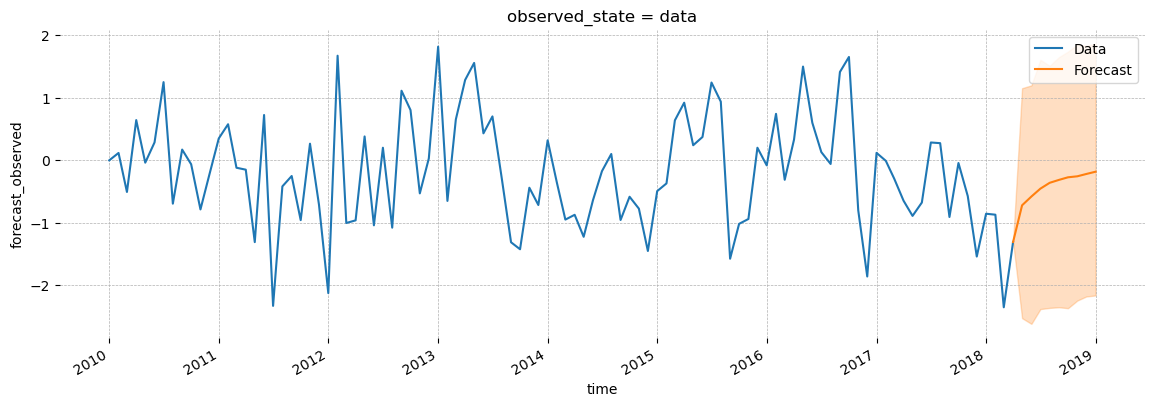

In [26]:
idata_forecast = ss_mod.forecast(idata, start=df.index[-1], periods=10)
forecast = idata_forecast.stack(sample=["chain", "draw"])
plot_forecast(df, forecast)

## Porcupine Graph

A "procupine graph" shows model forcasts at different periods in the time series. The name comes from the fact that forecasts lines poke out from the data like porcupine quills. We make one for this data to show the flexibility of the forecast method.

This isn't a true porcupine graph though, because the "forecasts" for the in-sample period are generated using parameters fit on data from the future. As noted, it's just a nice demonstration of the forecast method.

In [27]:
import warnings

idatas = []
for date in df.index[10::10]:
    with warnings.catch_warnings(category=UserWarning, action="ignore"):
        idata_forecast = ss_mod.forecast(
            idata, start=date, periods=5, filter_output="smoothed", progressbar=False
        )
    idatas.append(idata_forecast)

Sampling: [forecast_combined]
Sampling: [forecast_combined]
Sampling: [forecast_combined]
Sampling: [forecast_combined]
Sampling: [forecast_combined]
Sampling: [forecast_combined]
Sampling: [forecast_combined]
Sampling: [forecast_combined]
Sampling: [forecast_combined]


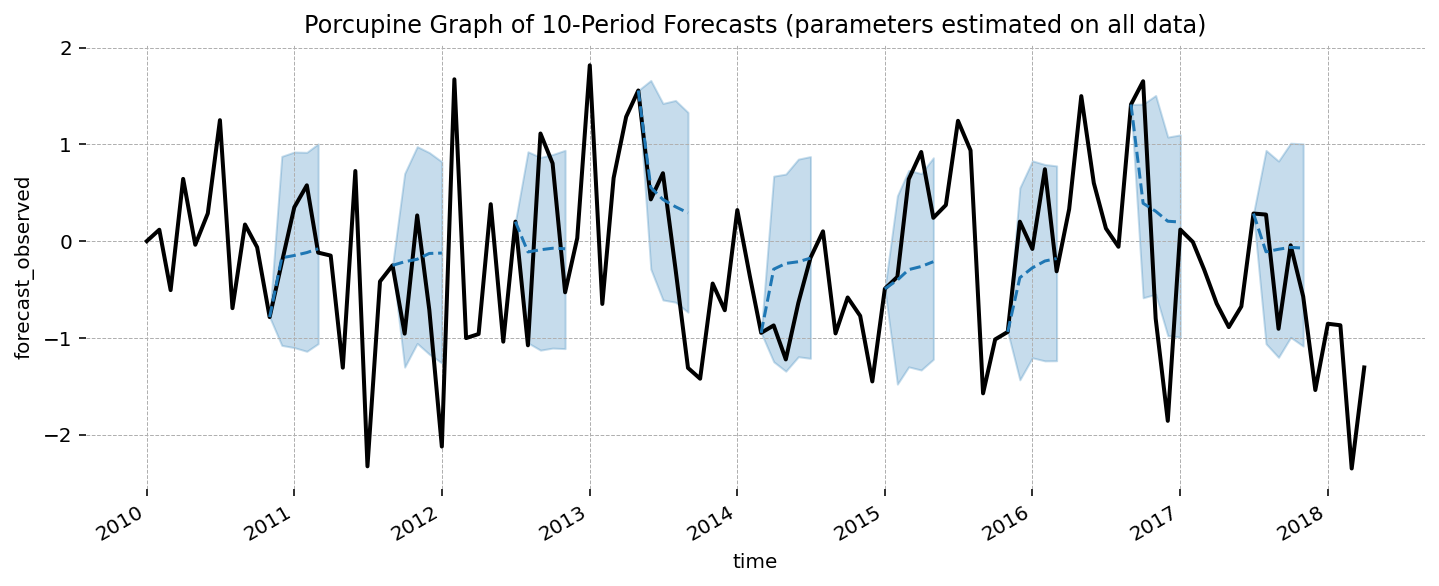

In [28]:
fig, ax = plt.subplots()
ax.plot(df.index, df.values, lw=2, c="k")

for idata_forecast in idatas:
    forecast = az.extract(idata_forecast)
    hdi_forecast = az.hdi(idata_forecast, hdi_prob=0.69).forecast_observed

    mean = forecast.mean(dim="sample").forecast_observed.isel(observed_state=0)
    mean.plot.line(x="time", color="tab:blue", ls="--")
    ax.fill_between(
        hdi_forecast.coords["time"].values,
        *hdi_forecast.isel(observed_state=0).values.T,
        alpha=0.25,
        color="tab:blue"
    )
ax.set_title("Porcupine Graph of 10-Period Forecasts (parameters estimated on all data)")
plt.show()

## Impulse Response Function

### Via posterior sampling of the shock matrix

/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/site-packages/pytensor/link/jax/linker.py:28: UserWarning: The RandomType SharedVariables [RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7F8A22192EA0>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [initial_shock]


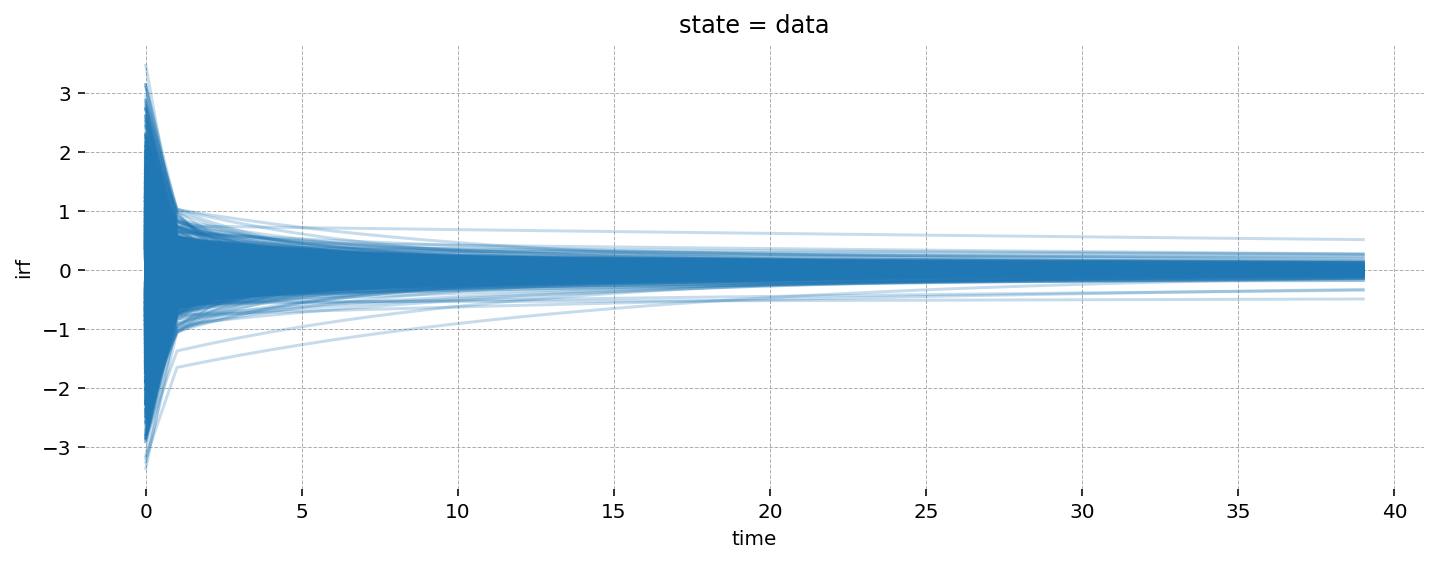

In [29]:
steps = 40
irf = ss_mod.impulse_response_function(idata, steps=steps, orthogonalize_shocks=True)

(
    irf.irf.isel(state=0)
    .stack(sample=["chain", "draw"])
    .plot.line(x="time", add_legend=False, color="tab:blue", alpha=0.25)
);

### Create a custom shock scenario

Sampling: []


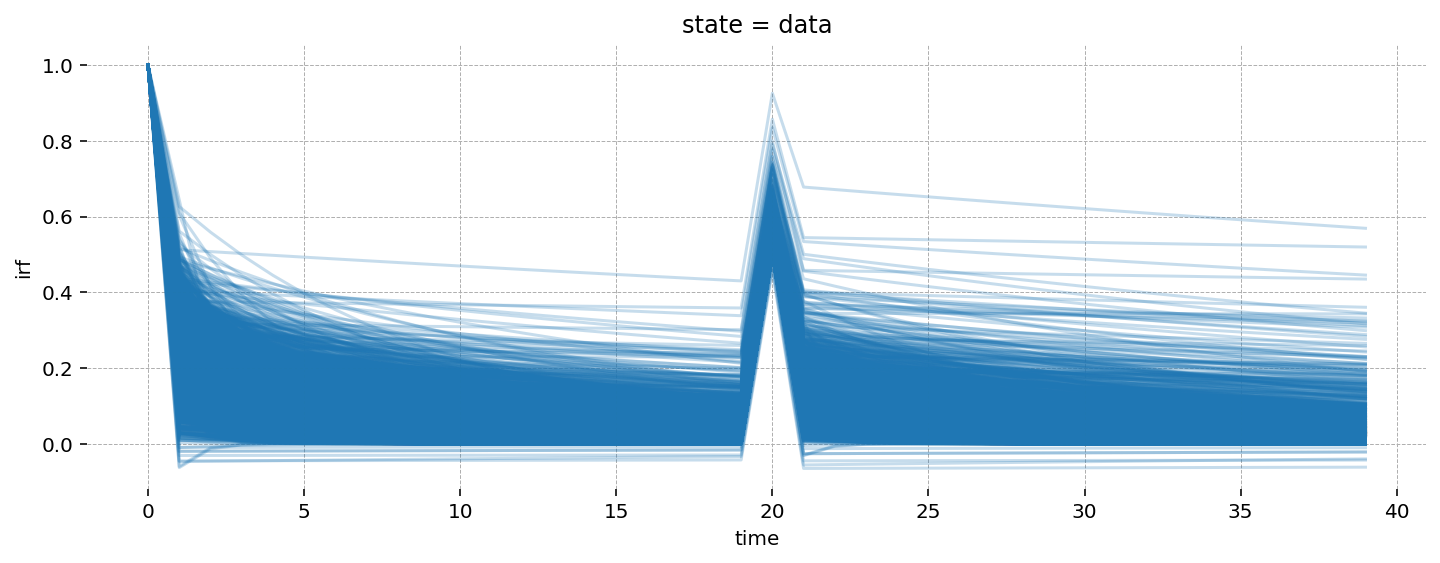

In [30]:
shock_trajectory = np.zeros((steps, ss_mod.k_posdef))
shock_trajectory[0] = 1
shock_trajectory[20] = 0.5

irf = ss_mod.impulse_response_function(idata, shock_trajectory=shock_trajectory)

(
    irf.irf.isel(state=0)
    .stack(sample=["chain", "draw"])
    .plot.line(x="time", add_legend=False, color="tab:blue", alpha=0.25)
);

## Interpretable ARMA

In addition to the usual formulation, there's also an "intrepretable" formulation of the ARMA model. It has significantly more states, which makes it a bad choice if speed is critical. But for a smallish model on smallish data, it lets us directly recover the innovation trajectory.

We can also add measurement error to the model, in case we have some reason to doubt the data. We'll also show off the missing data interpolation ability of the state space model.

In [31]:
ss_mod = pmss.BayesianARIMA(
    order=(1, 0, 1), state_structure="interpretable", measurement_error=True, verbose=True
)

The following parameters should be assigned priors inside a PyMC model block: 
	ar_params -- shape: (1,), constraints: None, dims: ('ar_lag',)
	ma_params -- shape: (1,), constraints: None, dims: ('ma_lag',)
	sigma_state -- shape: (1,), constraints: Positive, dims: ('observed_state',)
	sigma_obs -- shape: (1,), constraints: Positive, dims: ('observed_state',)


In [32]:
ss_mod.state_names

['data', 'innovations']

In [33]:
with pm.Model(coords=ss_mod.coords) as arma_model:
    state_sigmas = pm.HalfNormal("sigma_state", sigma=1.0, dims=ss_mod.param_dims["sigma_state"])
    obs_sigmas = pm.HalfNormal("sigma_obs", sigma=1.0, dims=ss_mod.param_dims["sigma_obs"])
    rho = pm.TruncatedNormal(
        "ar_params", mu=0.0, sigma=0.5, lower=-1.0, upper=1.0, dims=ss_mod.param_dims["ar_params"]
    )
    theta = pm.Normal("ma_params", mu=0.0, sigma=0.5, dims=ss_mod.param_dims["ma_params"])

    theta = ss_mod._gather_required_random_variables()
    ss_mod.build_statespace_graph(df, mode="JAX")

    idata = pm.sample(nuts_sampler="numpyro")

/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/site-packages/pymc/sampling/mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:07.367016
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:27.751014
Transforming variables...
Transformation time =  0:00:04.515340


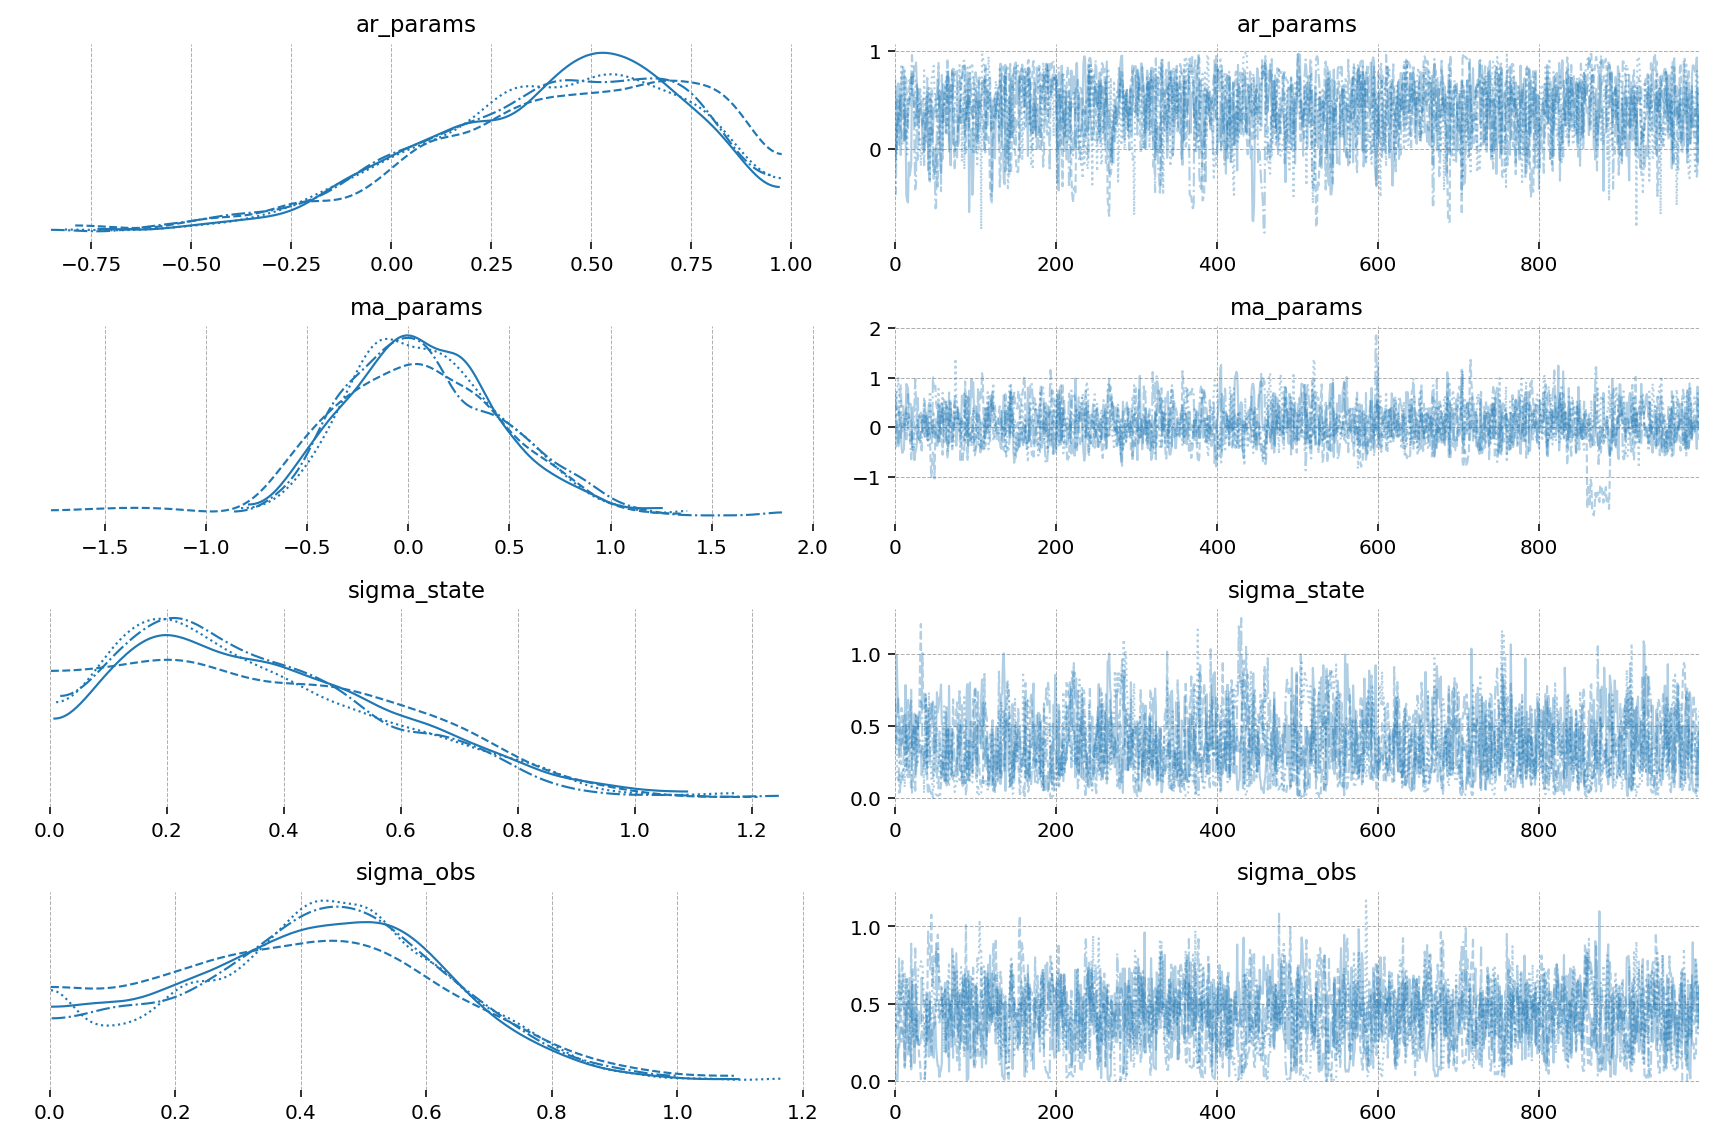

In [34]:
az.plot_trace(idata, var_names=ss_mod.param_names)
plt.tight_layout()

In [35]:
post_pred = ss_mod.sample_conditional_posterior(idata)

/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/site-packages/pytensor/link/jax/linker.py:28: UserWarning: The RandomType SharedVariables [RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7F8AAF441C40>), RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7F8AAF440900>), RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7F8AAF442260>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [filtered_posterior, predicted_posterior, smoothed_posterior]


We can see that the smoother output for the observed Data variable is no longer a perfect fit and has some posterior uncertainty resulting from measurement error. The hidden state is now the exact innovation series, unscaled by theta or lagged, which makes it easier to interpret, as advertised.

Also, since we are trusting the data less, the Smoother learns a lot less about the hidden state relative to the Filter -- the two are very similar.

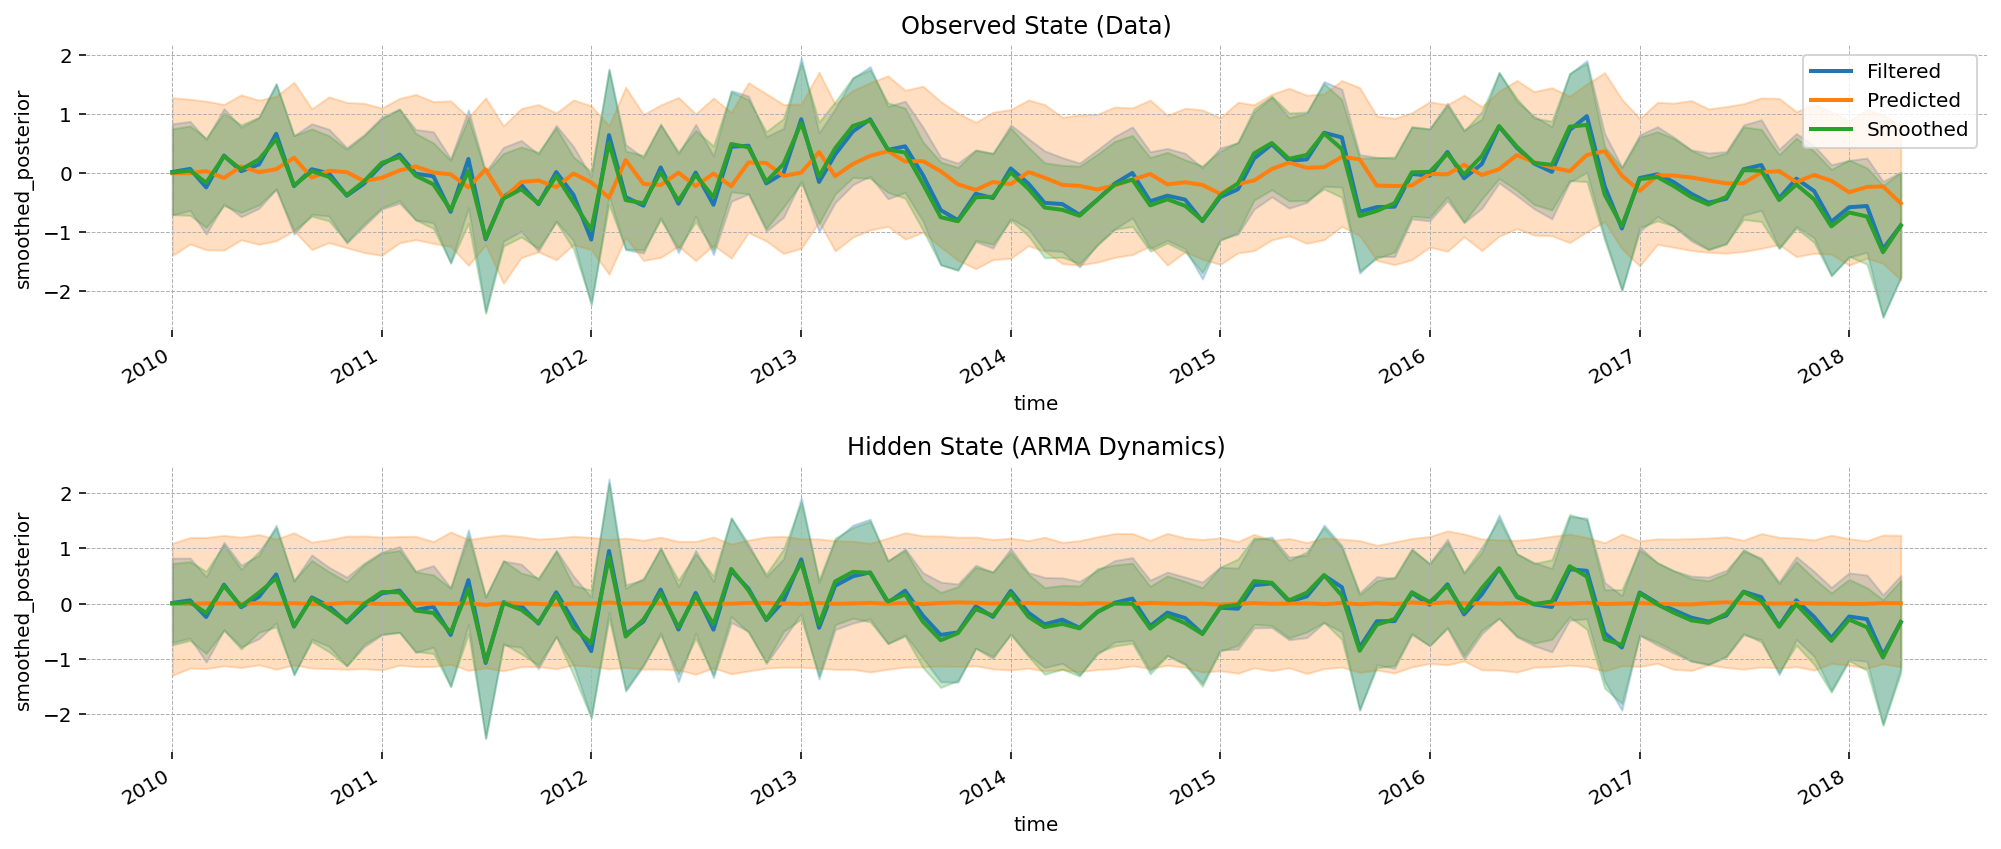

In [36]:
fig, ax = plt.subplots(2, 1, figsize=(14, 6), dpi=144)
post = az.extract(post_pred)
colors = ["tab:" + c for c in ["blue", "orange", "green"]]

for filter_output, color in zip(["filtered", "predicted", "smoothed"], colors):
    hdi = az.hdi(post_pred)[f"{filter_output}_posterior"]
    for idx, (axis, name) in enumerate(
        zip(fig.axes, ["Observed State (Data)", "Hidden State (ARMA Dynamics)"])
    ):
        post[f"{filter_output}_posterior"].isel(state=idx).mean(dim="sample").plot.line(
            x="time", ax=axis, lw=2, add_legend=False, label=filter_output.title(), color=color
        )
        axis.fill_between(
            hdi.coords["time"], *hdi.isel(state=idx).values.T, alpha=0.25, color=color
        )
        axis.set(title=name)

ax[0].legend()
fig.set_facecolor("w")
fig.tight_layout()
plt.show()

Use an IRF to illustrate that the innovations state really is just a record of the shocks

Sampling: []


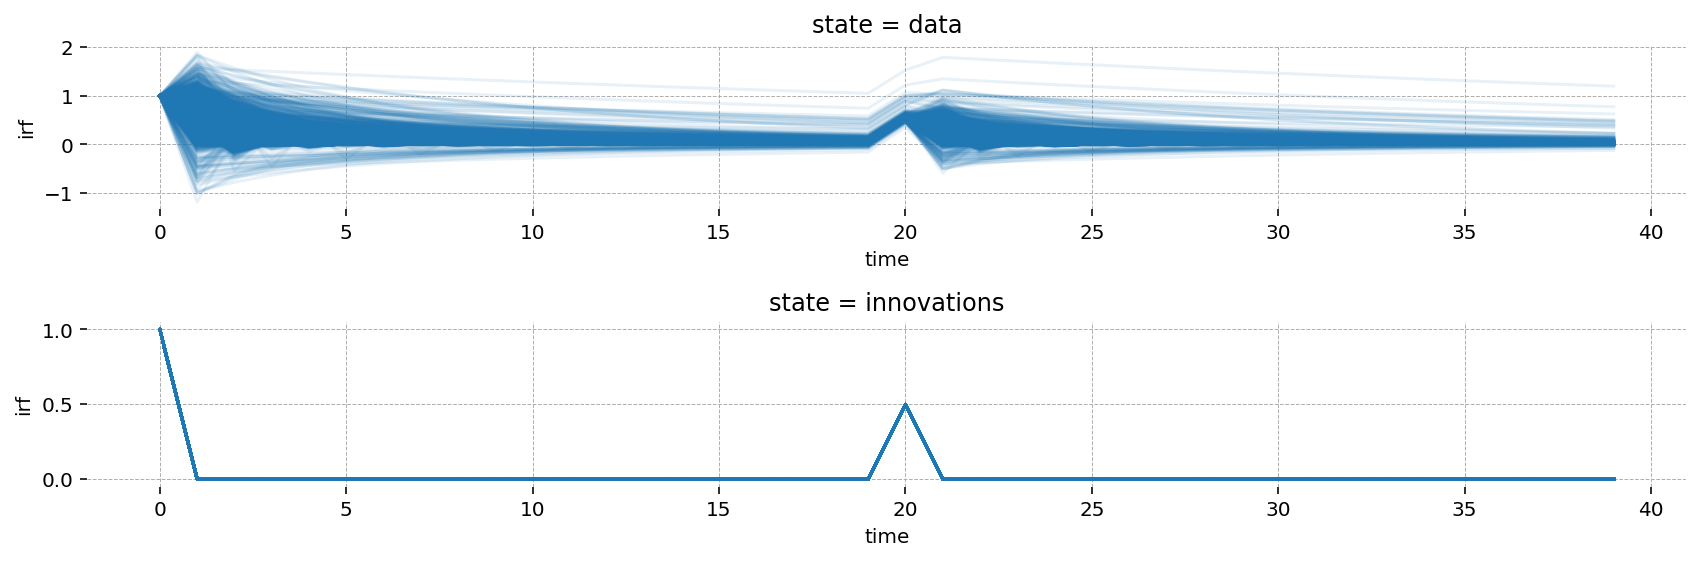

In [37]:
irf = ss_mod.impulse_response_function(idata, shock_trajectory=shock_trajectory)
fig, ax = plt.subplots(2, 1)
for axis, state in zip(fig.axes, ["data", "innovations"]):
    (
        irf.irf.sel(state=state)
        .stack(sample=["chain", "draw"])
        .plot.line(x="time", add_legend=False, color="tab:blue", alpha=0.1, ax=axis)
    )
plt.tight_layout()